# Multimodal RAG using ColPali (with Byaldi) and Qwen2-VL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/ColPali_%2B_Qwen2_VL.ipynb)


[ColPali](https://huggingface.co/blog/manu/colpali) is a multimodal retriever that removes the need for hefty and brittle document processors. It natively handles images and processes and encodes image patches to be compatible with text, thus removing need to do OCR, or image captioning.

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

After indexing data, we will use [Qwen2-VL-7B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) to do generation part in RAG.

[Byaldi](https://github.com/AnswerDotAI/byaldi) is a new library by answer.ai to easily use ColPali. This library is in a very early stage, so this notebook will likely be updated soon with API changes.

## Install Byaldi

We will install byaldi using pip to get started.

In [ ]:
!pip install --upgrade byaldi

In [ ]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (150 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123597 

We need to install transformers from main to get Qwen.

In [ ]:
!pip install -q pdf2image git+https://github.com/huggingface/transformers.git qwen-vl-utils flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Let's see how the PDF looks like.

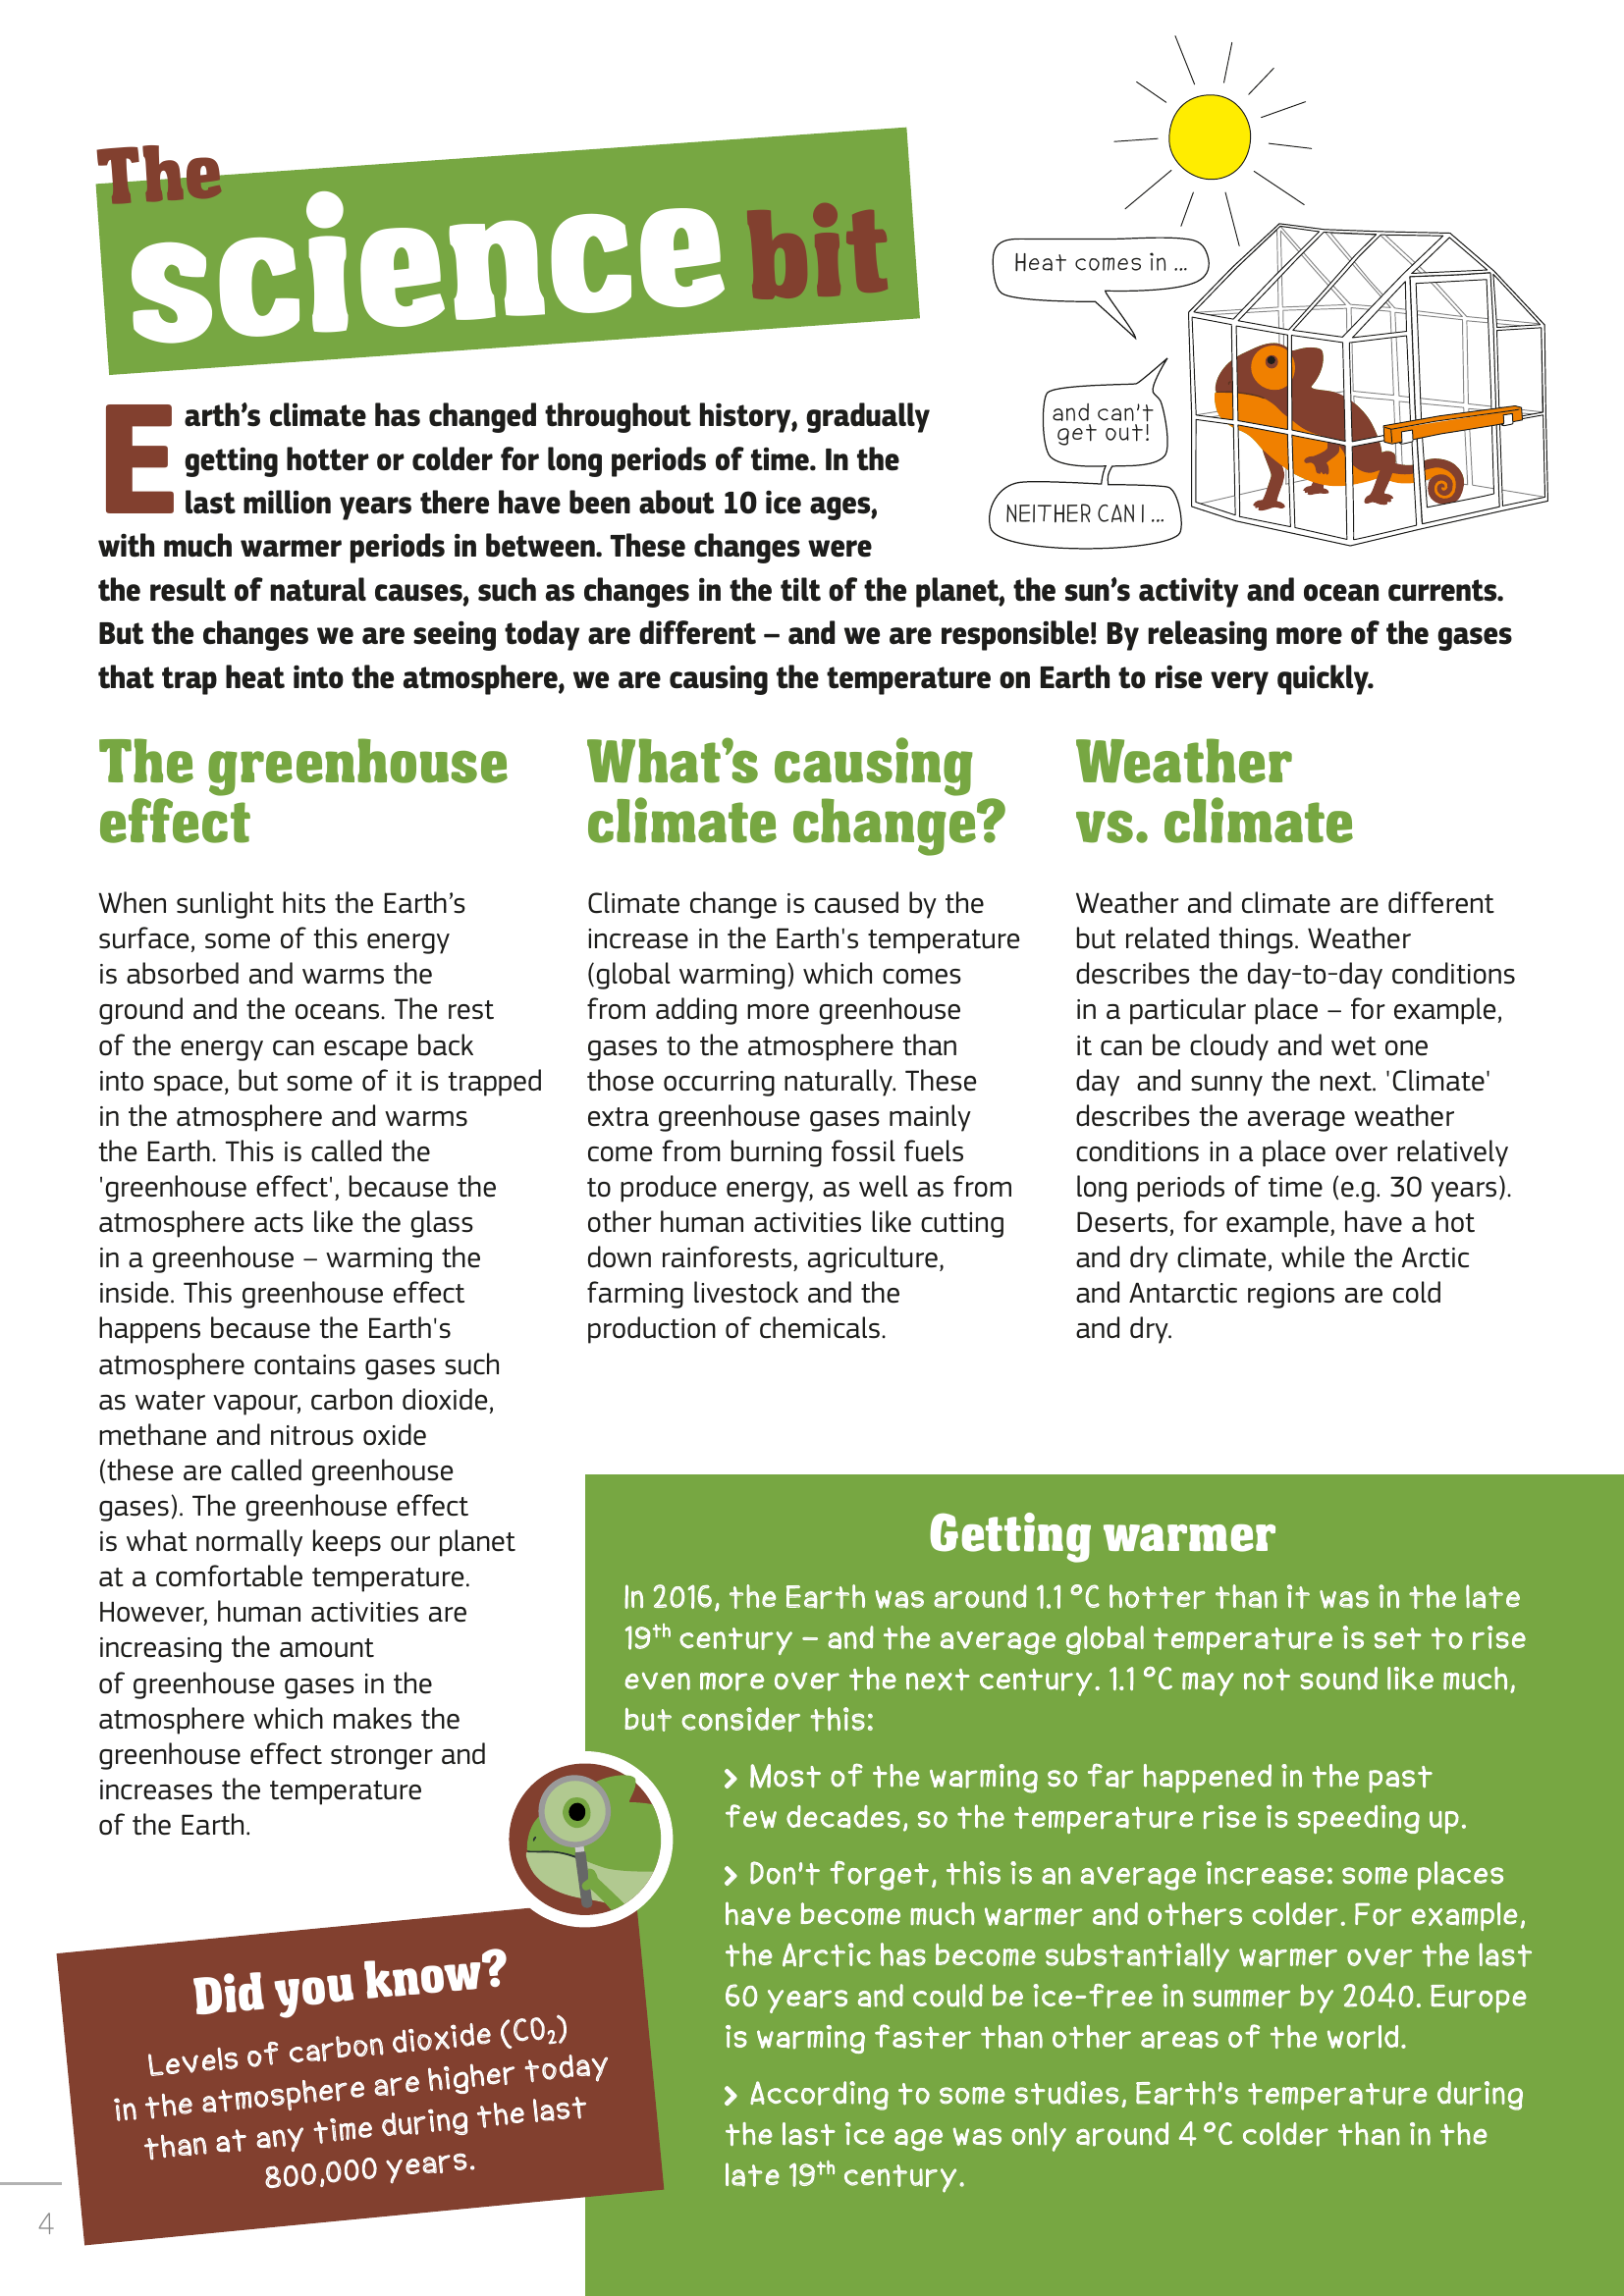

In [ ]:
from pdf2image import convert_from_path

images = convert_from_path("/content/climate_youth_magazine.pdf")
images[5]

We should initialize `RAGMultiModalModel` object with a ColPali model from Hugging Face. By default this model uses GPU but we are going to have Qwen2-VL in the same GPU so we are loading this in CPU for now.

In [ ]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

We can directly index our document using RAG, simply passing pdf file path is enough.

In [ ]:
RAG.index(
    input_path="/content/climate_youth_magazine.pdf",
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of document 0 to index.
Added page 26 of document 0 to index.
Added page 27 of docu

Now let's retrieve!

In [ ]:
text_query = "How much did the world temperature change so far?"
results = RAG.search(text_query, k=1)
results

[{'doc_id': 0, 'page_num': 6, 'score': 17.25, 'metadata': {}, 'base64': None}]

The answer was indeed on page 6, the one we accessed with `images[5]` above.

Now we can actually build a RAG pipeline. For this tutorial we will use Qwen2-VL-7B model.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).cuda().eval()

In [ ]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [ ]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


In [ ]:
print(output_text)

["The Earth's average global temperature has increased by around 1.1°C since the late 19th century, according to the information provided in the image."]


This is the correct answer!

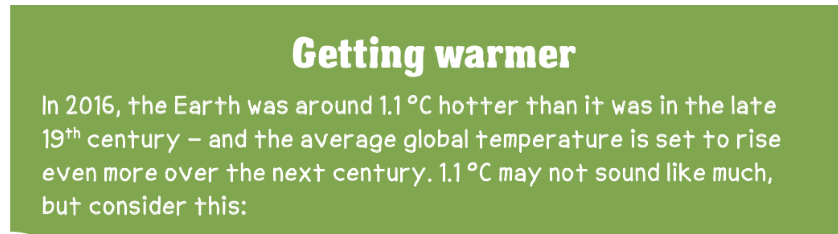